# Mosaicing the images

In [47]:
from osgeo import gdal

In [48]:
import os
os.chdir(r'E:\PYTHON-ASSIGNMENT\'mosaic')

In [49]:
file_names = ['ASTGTMV003_S21E047_dem.tif','ASTGTMV003_S22E047_dem.tif','ASTGTMV003_S22E048_dem.tif','ASTGTMV003_S21E048_dem.tif']


In [50]:
ds=gdal.Open(file_names[3])
print(ds)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000002A400BC47E0> >


In [51]:
# geotransform = ds.GetGeoTransform()
# originX = geotransform[0]
# originY = geotransform[3]
# OS Python week 4: Reading raster data [11]
# pixelWidth = geotransform[1]
# pixelHeight = geotransform[5]

def compute_extents(ds):
    trf = ds.GetGeoTransform()
    left = trf[0]
    right = trf[0]+trf[1]*ds.RasterXSize
    top = trf[3]
    bottom = trf[3]+trf[5]*ds.RasterYSize
    return(left,right,bottom,top)

In [52]:
ds_list = list()
for file in file_names:
    dataset = gdal.Open(file)
    ds_list.append(dataset)

In [53]:
mos_left,mos_right,mos_bottom,mos_top = compute_extents(ds_list[0])
mos_left

46.9998611111111

In [54]:
for i in range(1,len(file_names)):
    left,right,bottom,top = compute_extents(ds_list[i])
    mos_left = min(left,mos_left)
    mos_right = max(right,mos_right)
    mos_top = max(top,mos_top)
    mos_bottom = min(bottom,mos_bottom)

In [55]:
print(mos_left,mos_right,mos_bottom,mos_top)

46.9998611111111 49.00013888888888 -22.00013888888888 -19.9998611111111


In [56]:
prj = ds_list[0].GetProjection()

In [57]:
trf = ds_list[0].GetGeoTransform()

In [58]:
mos_trf = list(trf)
mos_trf

[46.9998611111111,
 0.000277777777777778,
 0.0,
 -19.9998611111111,
 0.0,
 -0.000277777777777778]

In [59]:
# mos_trf[0]=left
# mos_trf[3]=top


In [60]:
driver = gdal.GetDriverByName('GTiff')

In [61]:
import math

In [62]:
width = math.ceil((mos_right-mos_left)/mos_trf[1])
height = math.ceil((mos_bottom-mos_top)/mos_trf[5])

In [63]:
out_ds = driver.Create('final_mosaiced.tiff',width,height,eType=gdal.GDT_UInt16)
out_ds.SetProjection(prj)
out_ds.SetGeoTransform(mos_trf)

0

In [64]:
for ds in ds_list:
    trns = gdal.Transformer(ds,out_ds,[])
    suc,xyz = trns.TransformPoint(False,0,0)
    x,y,z = map(int,xyz)
    data_out = ds.GetRasterBand(1).ReadAsArray()
    out_ds.GetRasterBand(1).WriteArray(data_out,x,y)

In [65]:
mosaic_dataset = out_ds.ReadAsArray()

In [66]:
out_ds.BuildOverviews('average',[2,4,8,16,32])

0

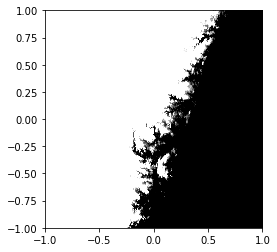

In [67]:
import matplotlib.pyplot as plt
# plt.figure(figsize=(10,10))
plt.imshow(mosaic_dataset,clim=(50,100),cmap=
          'gray',extent=([-1, 1, -1, 1]))

In [68]:
out_ds.FlushCache()
del ds_list